In [1]:
import numpy as np
from scipy.signal import convolve


def conforming_grid_convolution(F1, min1, max1, F2, min2, max2, p1=None, p2=None, run_checks=True, method='auto'):
    d = len(F1.shape)
    
    if p1 is None:
        p1 = np.zeros(d)
    if p2 is None:
        p2 = np.zeros(d)
        
    hh = (max1 - min1) / (np.array(F1.shape) - 1)
    
    if run_checks:
        hh2 = (max2 - min2) / (np.array(F2.shape) - 1)
        if np.linalg.norm(hh - hh2) > 1e-10:
            raise RuntimeError('Grids not conforming (different spacings h)')

        if (not is_divisible_by(min2 - min1, hh)):
            raise RuntimeError('Grids not conforming (one grid is shifted relative to the other)')
    
    element_volume = np.prod(hh)
    
    F3 = convolve(F1, F2, mode='full', method=method) * element_volume
    min3 = (min1 - p1) + (min2 - p2)
    max3 = (max1 - p1) + (max2 - p2)
    return F3, min3, max3


def is_divisible_by(xx, yy, tol=1e-10):
    return np.linalg.norm(xx / yy - np.rint(xx / yy)) < tol

# Test

In [2]:
import matplotlib.pyplot as plt
from time import time


min1 = np.array([0.23, -0.35])
hh = np.array([0.0125, 0.01])
min2 = min1 + np.array([30., 57.]) * hh
# min2 = np.array([-0.14, 0.22])

F1_shape = (95,87)
F2_shape = (151,198)

max1 = min1 + hh * (np.array(F1_shape)-1)
max2 = min2 + hh * (np.array(F2_shape)-1)

p1 = np.array([0.35, -0.25])
p2 = np.array([1.35, 1.25])

xx1 = np.linspace(min1[0], max1[0], F1_shape[0])
yy1 = np.linspace(min1[1], max1[1], F1_shape[1])
X1, Y1 = np.meshgrid(xx1, yy1, indexing='ij')

xx2 = np.linspace(min2[0], max2[0], F2_shape[0])
yy2 = np.linspace(min2[1], max2[1], F2_shape[1])
X2, Y2 = np.meshgrid(xx2, yy2, indexing='ij')

F1_volume= 1.35


Text(0.5, 1.0, 'F1')

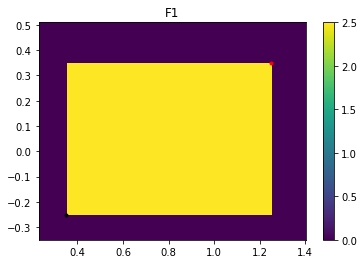

In [3]:
b_width = 0.9
b_height = 0.6

F1 = 2.5 * (p1[0] < X1) * (X1 < p1[0] + b_width) * (p1[1] < Y1) * (Y1 < p1[1] + b_height)

element_volume = np.prod(hh)
F1_volume = np.sum(F1) * element_volume
print('F1_volume=', F1_volume)

plt.pcolor(X1, Y1, F1)
plt.colorbar()
plt.plot(p1[0], p1[1], '.k')
plt.plot(p1[0] + b_width, p1[1] + b_height, '.r')
plt.title('F1')

F2_volume= 0.9999984661196422


Text(0.5, 1.0, 'F2')

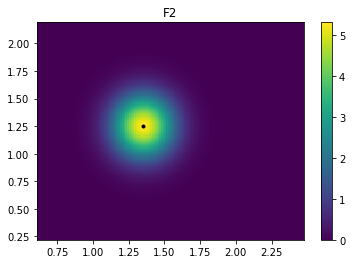

In [4]:
ss = np.array([0.15, 0.2])
det_Sigma = np.prod(ss**2)
d = len(ss)
C = np.power(2 * np.pi, -d/2.) * np.power(det_Sigma, -1./2.)

F2 = C * np.exp(-0.5 * (X2 - p2[0])**2 / ss[0]**2 - 0.5 * (Y2 - p2[1])**2 / ss[1]**2)

F2_volume = np.sum(F2) * element_volume
print('F2_volume=', F2_volume)

plt.pcolor(X2, Y2, F2)
plt.colorbar()
plt.plot(p2[0], p2[1], '.k')
plt.title('F2')

dt_fft= 0.004469871520996094
dt_direct= 5.467124700546265
dt_auto= 0.0024950504302978516
F3_volume= 1.349997929261517


Text(0.5, 1.0, 'convolution of f1(x-p1) and f2(x-p2)')

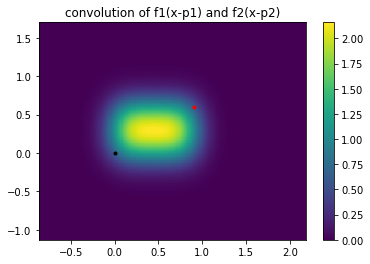

In [5]:
t = time()
F3, min3, max3 = conforming_grid_convolution(F1, min1, max1, F2, min2, max2, p1=p1, p2=p2, method='fft')
dt_fft = time() - t
print('dt_fft=', dt_fft)

t = time()
F3, min3, max3 = conforming_grid_convolution(F1, min1, max1, F2, min2, max2, p1=p1, p2=p2, method='direct')
dt_direct = time() - t
print('dt_direct=', dt_direct)

t = time()
F3, min3, max3 = conforming_grid_convolution(F1, min1, max1, F2, min2, max2, p1=p1, p2=p2, method='auto')
dt_auto = time() - t
print('dt_auto=', dt_auto)

F3_volume = np.sum(F3) * element_volume
print('F3_volume=', F3_volume)

xx3 = np.linspace(min3[0], max3[0], F3.shape[0])
yy3 = np.linspace(min3[1], max3[1], F3.shape[1])
X3, Y3 = np.meshgrid(xx3, yy3, indexing='ij')

plt.pcolor(X3, Y3, F3)
plt.colorbar()

plt.plot(0, 0, '.k')
plt.plot(b_width, b_height, '.r')
plt.title('convolution of f1(x-p1) and f2(x-p2)')